In [1]:
# Importing relevant packages
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Below here is the way to load all the data into the dataframe in less time

In [2]:
import dask.dataframe as dd
from tqdm import tqdm

TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

In [3]:
# Based on ref: https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows#
#%%time
import subprocess

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])+1

n_rows = file_len(TRAIN_PATH)
print (f'Exact number of rows Train_Set: {n_rows}')

n_rows = file_len(TEST_PATH)
print (f'Exact number of rows Test_Set: {n_rows}')

Exact number of rows Train_Set: 55423857
Exact number of rows Test_Set: 9915


In [4]:
df_tmp = pd.read_csv(TRAIN_PATH, nrows=5)
df_tmp.info()

df_tmp_test = pd.read_csv(TEST_PATH, nrows=5)
df_tmp_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
key                  5 non-null object
fare_amount          5 non-null float64
pickup_datetime      5 non-null object
pickup_longitude     5 non-null float64
pickup_latitude      5 non-null float64
dropoff_longitude    5 non-null float64
dropoff_latitude     5 non-null float64
passenger_count      5 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 400.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
key                  5 non-null object
pickup_datetime      5 non-null object
pickup_longitude     5 non-null float64
pickup_latitude      5 non-null float64
dropoff_longitude    5 non-null float64
dropoff_latitude     5 non-null float64
passenger_count      5 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 360.0+ bytes


In [5]:
# optimize for memory usage
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

testtypes = { 'key': 'str',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols_test = list(testtypes.keys())

In [6]:
chunksize = 5_000_000
chunksize_test = 1_000

In [7]:
# based on ref: https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows#
#%%time
df_list = []

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize)):
     
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df_list.append(df_chunk) 

12it [01:36,  6.33s/it]


In [8]:
#%%time
df_list_test = []

for df_chunk in tqdm(pd.read_csv(TEST_PATH, usecols=cols_test, dtype=testtypes, chunksize=chunksize_test)):
     
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df_list_test.append(df_chunk) 

10it [00:00, 11.19it/s]


In [9]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)
test_df = pd.concat(df_list_test)

# Delete the dataframe list to release memory
del df_list
del df_list_test

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float32
pickup_latitude      9914 non-null float32
dropoff_longitude    9914 non-null float32
dropoff_latitude     9914 non-null float32
passenger_count      9914 non-null uint8
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [10]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00+00:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00+00:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00+00:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00+00:00,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00+00:00,-73.969719,40.797668,-73.970886,40.783314,1


In [11]:
display(test_df.head())
display(test_df.tail())

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966049,40.789776,-73.988564,40.744427,1


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:00+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:00+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:00+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:00+00:00,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:23.0000006,2015-01-18 14:06:00+00:00,-73.988022,40.754070,-74.000282,40.759220,6


In [12]:
# Save the raw 55 million rows of training data into the feather format, similarly for test data
train_df.to_feather('nyc_taxi_data_TRAIN_raw.feather')
test_df.to_feather('nyc_taxi_data_TEST_raw.feather')

In [13]:
# load the same dataframe directly
train_df_new = pd.read_feather('nyc_taxi_data_TRAIN_raw.feather')
test_df_new = pd.read_feather('nyc_taxi_data_TEST_raw.feather')

In [14]:
train_df_new.info()
test_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float32
pickup_latitude      9914 non-null float32
dropoff_longitude    9914 non-null float32
dropoff_latitude     9914 non-null float32
passenger_count      9914 non-null uint8
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


## End of way to load all the data into the dataframe

In [15]:
# looking at some of the description of the training data
train_df_new.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134503e+01,-7.250972e+01,3.991985e+01,-7.251106e+01,3.992067e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [16]:
# description of the testing data
test_df_new.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


# some problems that are noticable from describe() on all the train data

1. min for fare_amount -300?? not possible. taxi cab actually gave money to passenger lol, prob a robbery!
2. max for fare_amount 93963?? too high!
3. min pickup_longitude -3442.060?? NY longitude is ~ -73
    - 'Latitude must be in the [-90; 90] range.
4. max pickup_longitude 3457.62?? again NY longitude is ~-73
5. std is pickup_lattitude is ~ 9.64, 1 lattitude changed is ~ 69 miles!
6. min and max pickup_lattitude again -3492.26 and 3408.70 respectively, NY latitude is ~40!
7. again min and max large numbers in dropoff_longitude!
8. again min and max large numbers in dropoff_latitude along with high std value
9. 0 passenger count and 208 passenger count (party bus haha?) 

**Additional imp info**
NY city has a radius of ~ 30 miles hence, following should be reasonable assumption:

(a) A degree difference in latitude is ~ 69 miles, hence only data within 1 degree of NY latitude should be most relevant. I'll choose 1.4, here.

(b) A degree of longitude is widest at the equator at 69.172 miles (111.321) and gradually shrinks to zero at the poles. At 40° north or south the distance between a degree of longitude is 53 miles (85 km). New York is at ~ 40 N latitude, hence, data within 1 degree of the NY longitude value should be the most relevant. I'll choose 1.4 here.

(c) For the purpose of cleaning up the data, I'll assume center point of the NY city to be at latitude = 40.7128 and longitude = -74.0060. This info was obtained from google.


# Overall the above points suggest training data needs cleanup to remove the outliers for accurate general taxi cab predictions

# Hence below from here is cleaning/optimization of the data

In [17]:
#remove the null data points from training set
train_df_copy = train_df_new.copy()

print(train_df_copy.isnull().sum())

print('Old size: %d' % len(train_df_copy))
train_df_copy = train_df_copy.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df_copy))

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64
Old size: 55423856
New size: 55423480


In [18]:
#remove the null data points from testing set
test_df_copy = test_df_new.copy()

print(test_df_copy.isnull().sum())

print('Old size: %d' % len(test_df_copy))
test_df_copy = test_df_copy.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(test_df_copy))

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
Old size: 9914
New size: 9914


In [19]:
# exclude the data with negative fare_amount from the training set
print('Old size: %d' % len(train_df_copy))
train_df_copy = train_df_copy[train_df_copy.fare_amount >= 0.0]
print('New size: %d' % len(train_df_copy))

Old size: 55423480
New size: 55421026


In [20]:
# Here we exclude the training data outside the 1.4 degree of the New York city center point latitude 
# from the pickup_latitude feature
NY_center_lat = 40.7128

print('Old size: %d' % len(train_df_copy))
train_df_copy = train_df_copy[(train_df_copy.pickup_latitude<=(NY_center_lat+1.4)) & (train_df_copy.pickup_latitude>=(NY_center_lat-1.4))]
print('New size: %d' % len(train_df_copy))

Old size: 55421026
New size: 54332687


In [21]:
# Here we exclude the training data outside the 1.4 degree of the New York city center point 
# longitude from the pickup_longitude feature
NY_center_long = -74.0060

print('Old size: %d' % len(train_df_copy))
train_df_copy = train_df_copy[(train_df_copy.pickup_longitude<=(NY_center_long+1.4)) & (train_df_copy.pickup_longitude>=(NY_center_long-1.4))]
print('New size: %d' % len(train_df_copy))

Old size: 54332687
New size: 54321247


In [22]:
# Here we exclude training data outside the 1.4 degree of the New York city center point latitude from 
# the dropoff_latitude feature
NY_center_lat = 40.7128

print('Old size: %d' % len(train_df_copy))
train_df_copy = train_df_copy[(train_df_copy.dropoff_latitude<=(NY_center_lat+1.4)) & (train_df_copy.dropoff_latitude>=(NY_center_lat-1.4))]
print('New size: %d' % len(train_df_copy))

Old size: 54321247
New size: 54273435


In [23]:
# Here we exclude the training data outside the 1.4 degree of the New York city center point 
# longitude from the dropoff_longitude feature
NY_center_long = -74.0060

print('Old size: %d' % len(train_df_copy))
train_df_copy = train_df_copy[(train_df_copy.dropoff_longitude<=(NY_center_long+1.4)) & (train_df_copy.dropoff_longitude>=(NY_center_long-1.4))]
print('New size: %d' % len(train_df_copy))

Old size: 54273435
New size: 54265774


Text(0, 0.5, 'Frequency')

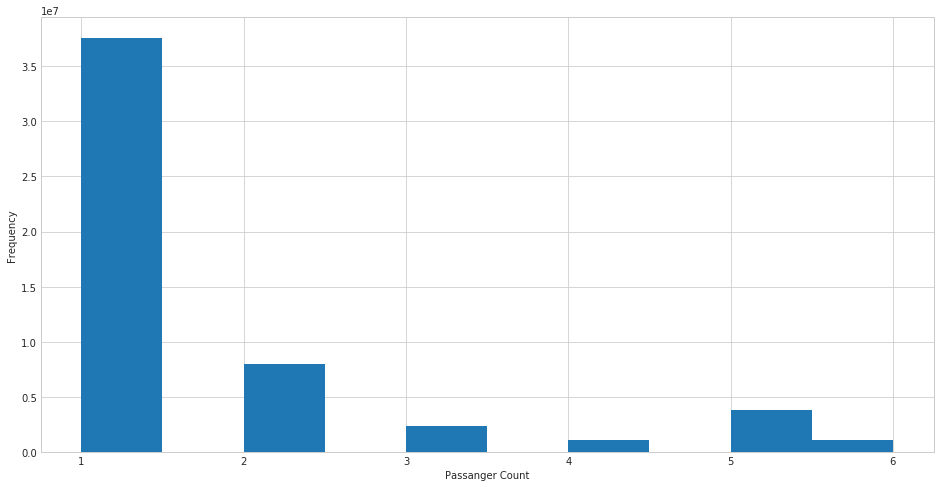

In [24]:
# checking for passanger count less than equal to 6 and more than equal to 1
train_df_copy[(train_df_copy.passenger_count <=6) & (train_df_copy.passenger_count >=1)].passenger_count.hist(bins=10, figsize = (16,8))
plt.xlabel("Passanger Count")
plt.ylabel("Frequency")

In [25]:
# at best 6 passengers would be able to fit in the regular taxi cab, hence remove training data outside that range
print('Old size: %d' % len(train_df_copy))
train_df_copy = train_df_copy[train_df_copy.passenger_count<=6]
print('New size: %d' % len(train_df_copy))

Old size: 54265774
New size: 54265709


In [26]:
# assume at least 1 passenger needs to be in the taxi for the fare to charged, fix training data accordingly
print('Old size: %d' % len(train_df_copy))
train_df_copy = train_df_copy[train_df_copy.passenger_count>=1]
print('New size: %d' % len(train_df_copy))

Old size: 54265709
New size: 54074867


Text(0, 0.5, 'Frequency')

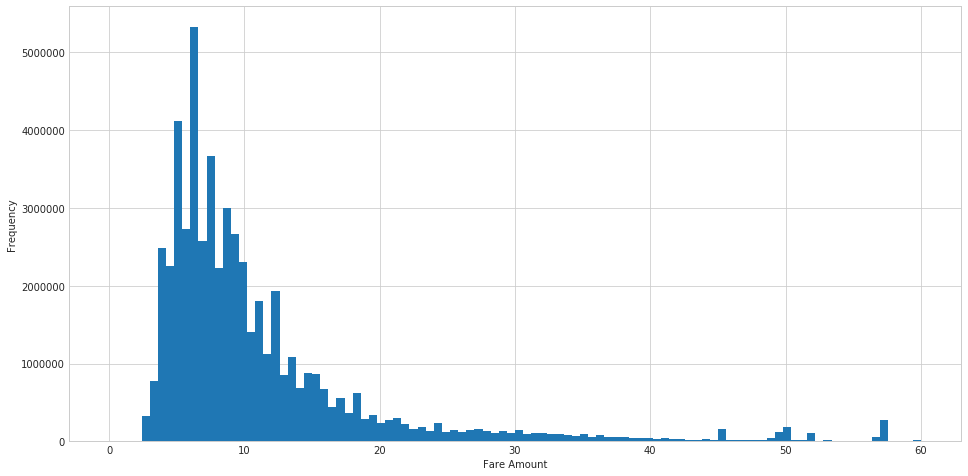

In [27]:
# distribution of fare amount less than or equal to 60 and more than or equal to 0
train_df_copy[(train_df_copy.fare_amount <=60.0) & (train_df_copy.fare_amount >=0.0)].fare_amount.hist(bins=100, figsize = (16,8))

plt.xlabel("Fare Amount")
plt.ylabel("Frequency")

In [28]:
# There are some values in the fare_amount that is too high and may cause skewness in the prediction towards higher fare
# Hence, I'll be removing all the fare_amount > 60.0, assume them to be rare occurences that might have other factors
# that is raising the cost, other than the given features.

print('Old size: %d' % len(train_df_copy))
store_old = len(train_df_copy)

train_df_copy = train_df_copy[train_df_copy.fare_amount<= 60.0]

print('New size: %d' % len(train_df_copy))
store_new = len(train_df_copy)

percentage_data_retained = float(store_new)/store_old*100
print('% of data remained with fare_amount outlier removal: '+ str(percentage_data_retained))

Old size: 54074867
New size: 53937364
% of data remained with fare_amount outlier removal: 99.74571735886101


In [29]:
# Description of the cleaned data
train_df_copy.describe()

# The values for all the features seem much more reasonable now

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.393736e+07,5.393736e+07,5.393736e+07,5.393736e+07,5.393736e+07,5.393736e+07
mean,1.115018e+01,-7.397075e+01,4.075011e+01,-7.397047e+01,4.075020e+01,1.691199e+00
std,8.900388e+00,3.952340e-02,3.182299e-02,3.751599e-02,3.484949e-02,1.307090e+00
min,0.000000e+00,-7.540568e+01,3.932974e+01,-7.540594e+01,3.931842e+01,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073658e+01,-7.399155e+01,4.073571e+01,1.000000e+00
50%,8.500000e+00,-7.398209e+01,4.075338e+01,-7.398058e+01,4.075390e+01,1.000000e+00
75%,1.250000e+01,-7.396832e+01,4.076756e+01,-7.396534e+01,4.076840e+01,2.000000e+00
max,6.000000e+01,-7.260983e+01,4.210696e+01,-7.261128e+01,4.211272e+01,6.000000e+00


In [30]:
display(train_df_copy.head())
display(train_df_copy.tail())
print(len(train_df_copy))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00+00:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00+00:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00+00:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00+00:00,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00+00:00,-73.969719,40.797668,-73.970886,40.783314,1


53937364


In [31]:
# reset the index of the training data
train_df_new_CLEANED = train_df_copy.reset_index(drop=True)
display(train_df_new_CLEANED.head())
display(train_df_new_CLEANED.tail())
print(len(train_df_new_CLEANED))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
53937359,14.0,2014-03-15 03:28:00+00:00,-74.005272,40.740028,-73.963280,40.762554,1
53937360,4.2,2009-03-24 20:46:00+00:00,-73.957787,40.765530,-73.951637,40.773960,1
53937361,14.1,2011-04-02 22:04:00+00:00,-73.970505,40.752323,-73.960541,40.797340,1
53937362,28.9,2011-10-26 05:57:00+00:00,-73.980904,40.764629,-73.870605,40.773964,1
53937363,7.5,2014-12-12 11:33:00+00:00,-73.969719,40.797668,-73.970886,40.783314,1


53937364


In [32]:
# Save THE CLEANED training DATA into feather format
train_df_new_CLEANED.to_feather('nyc_taxi_data_TRAIN_CLEANED.feather')

In [33]:
# load the same dataframe next time directly
train_df_throwaway = pd.read_feather('nyc_taxi_data_TRAIN_CLEANED.feather')

In [34]:
train_df_throwaway.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.393736e+07,5.393736e+07,5.393736e+07,5.393736e+07,5.393736e+07,5.393736e+07
mean,1.115018e+01,-7.397075e+01,4.075011e+01,-7.397047e+01,4.075020e+01,1.691199e+00
std,8.900388e+00,3.952340e-02,3.182299e-02,3.751599e-02,3.484949e-02,1.307090e+00
min,0.000000e+00,-7.540568e+01,3.932974e+01,-7.540594e+01,3.931842e+01,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073658e+01,-7.399155e+01,4.073571e+01,1.000000e+00
50%,8.500000e+00,-7.398209e+01,4.075338e+01,-7.398058e+01,4.075390e+01,1.000000e+00
75%,1.250000e+01,-7.396832e+01,4.076756e+01,-7.396534e+01,4.076840e+01,2.000000e+00
max,6.000000e+01,-7.260983e+01,4.210696e+01,-7.261128e+01,4.211272e+01,6.000000e+00


# Some feature engineering below, I believe only hour of the day and year (only little bit) will have affect on fare_amount, hence I'll extract them and then drop timestamp column

In [35]:
# function to extract hour and year from pickup_datetime timestamp
import time
def extract_hr_year(df):
    
    df['hour_of_day'] = df.pickup_datetime.dt.hour
    df["year"] = df.pickup_datetime.dt.year
    
    return df

In [36]:
# make changes to the pickup_datetime timestamp in the training and testing data
train_datetime_fixed = extract_hr_year(train_df_throwaway)
test_datetime_fixed = extract_hr_year(test_df_copy)

In [37]:
train_datetime_fixed.info()
test_datetime_fixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53937364 entries, 0 to 53937363
Data columns (total 9 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
hour_of_day          int64
year                 int64
dtypes: datetime64[ns, UTC](1), float32(5), int64(2), uint8(1)
memory usage: 2.3 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9913
Data columns (total 9 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float32
pickup_latitude      9914 non-null float32
dropoff_longitude    9914 non-null float32
dropoff_latitude     9914 non-null float32
passenger_count      9914 non-null uint8
hour_of_day          9914 non-null int64
year                 9914 non-null int64
dtypes: datetime64[ns, UTC](1), float

In [38]:
# added hour_of_day and year feature to the training and testing set
display(train_datetime_fixed.head())
display(test_datetime_fixed.head())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1,17,2009
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1,16,2010
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2,0,2011
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1,4,2012
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1,7,2010


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,13,2015
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,13,2015
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982521,40.751259,-73.979652,40.746140,1,11,2011
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981163,40.767807,-73.990448,40.751637,1,21,2012
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966049,40.789776,-73.988564,40.744427,1,21,2012


In [39]:
# removed pickup_datetime feature now, since extracted hour_of_day and year feature
columns = ['pickup_datetime']
train_df_eng = train_datetime_fixed.drop(columns, 1)
test_df_eng = test_datetime_fixed.drop(columns, 1)

In [40]:
train_df_eng.info()
display(train_df_eng.head())

# reset the index
train_df_new_ENG= train_df_eng.reset_index(drop=True)

# Save THE TRAIN Engineered DATA into feather format
train_df_new_ENG.to_feather('nyc_taxi_data_TRAIN_ENG.feather')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53937364 entries, 0 to 53937363
Data columns (total 8 columns):
fare_amount          float32
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
hour_of_day          int64
year                 int64
dtypes: float32(5), int64(2), uint8(1)
memory usage: 1.9 GB


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,4.5,-73.844315,40.721317,-73.841614,40.712276,1,17,2009
1,16.9,-74.016045,40.711304,-73.979271,40.782005,1,16,2010
2,5.7,-73.982735,40.761269,-73.991241,40.750561,2,0,2011
3,7.7,-73.987129,40.733143,-73.991570,40.758091,1,4,2012
4,5.3,-73.968094,40.768009,-73.956657,40.783764,1,7,2010


In [41]:
test_df_eng.info()
display(test_df_eng.head())

# reset the index
test_df_new_ENG= test_df_eng.reset_index(drop=True)

# Save THE TEST Engineered DATA into feather format
test_df_new_ENG.to_feather('nyc_taxi_data_TEST_ENG.feather')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9913
Data columns (total 8 columns):
key                  9914 non-null object
pickup_longitude     9914 non-null float32
pickup_latitude      9914 non-null float32
dropoff_longitude    9914 non-null float32
dropoff_latitude     9914 non-null float32
passenger_count      9914 non-null uint8
hour_of_day          9914 non-null int64
year                 9914 non-null int64
dtypes: float32(4), int64(2), object(1), uint8(1)
memory usage: 474.4+ KB


,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,13,2015
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,13,2015
2,2011-10-08 11:53:44.0000002,-73.982521,40.751259,-73.979652,40.746140,1,11,2011
3,2012-12-01 21:12:12.0000002,-73.981163,40.767807,-73.990448,40.751637,1,21,2012
4,2012-12-01 21:12:12.0000003,-73.966049,40.789776,-73.988564,40.744427,1,21,2012


# Below here I'll be doing standard scaling of the features utilizing sklearn standard scaler

In [42]:
# remove the 'key' column from the testing set so that we can apply SCALING to the test data
columns = ['key']
test_df_eng_NO_key = test_df_eng.drop(columns, 1)

display(test_df_eng_NO_key.head())

# remove the 'fare_amount' column from the training data so that we can apply SCALING to the 
# training data consistent with the testing data
columns = ['fare_amount']
train_df_eng_NO_fare = train_df_eng.drop(columns, 1)

display(train_df_eng_NO_fare.head())

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,-73.973320,40.763805,-73.981430,40.743835,1,13,2015
1,-73.986862,40.719383,-73.998886,40.739201,1,13,2015
2,-73.982521,40.751259,-73.979652,40.746140,1,11,2011
3,-73.981163,40.767807,-73.990448,40.751637,1,21,2012
4,-73.966049,40.789776,-73.988564,40.744427,1,21,2012


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,-73.844315,40.721317,-73.841614,40.712276,1,17,2009
1,-74.016045,40.711304,-73.979271,40.782005,1,16,2010
2,-73.982735,40.761269,-73.991241,40.750561,2,0,2011
3,-73.987129,40.733143,-73.991570,40.758091,1,4,2012
4,-73.968094,40.768009,-73.956657,40.783764,1,7,2010


In [43]:
# remove all coloumns except the fare_amount from the training set
columns = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour_of_day','year']
train_df_fare = train_df_eng.drop(columns, 1)

In [44]:
display(train_df_fare.head())

,fare_amount
0,4.5
1,16.9
2,5.7
3,7.7
4,5.3


In [45]:
# scaling and transforming training data
scaler = StandardScaler()
scaler.fit(train_df_eng_NO_fare)
std_scaled_train_data = scaler.transform(train_df_eng_NO_fare)

# save the scaler
scaler_filename = "scaler_train.save"
joblib.dump(scaler, scaler_filename) 

['scaler_train.save']

In [46]:
# scaling and transforming fare_amount data (which will be our target feature)
scaler_fare = StandardScaler()
scaler_fare.fit(train_df_fare)
std_scaled_fare_data = scaler_fare.transform(train_df_fare)

# save the scaler used for scaling fare_amount data in the training data
scaler_filename = "scaler_fare.save"
joblib.dump(scaler_fare, scaler_filename)

['scaler_fare.save']

In [47]:
#Creating pandas dataframe from numpy array for the scaled training set
std_train_df_scaled_data = pd.DataFrame({'fare_amount':std_scaled_fare_data[:,0],'pickup_longitude':std_scaled_train_data[:,0],\
                                     'pickup_latitude':std_scaled_train_data[:,1],'dropoff_longitude':std_scaled_train_data[:,2],\
                                     'dropoff_latitude':std_scaled_train_data[:,3],'passenger_count':std_scaled_train_data[:,4],\
                                     'hour_of_day':std_scaled_train_data[:,5],'year':std_scaled_train_data[:,6]})
display(std_train_df_scaled_data.head())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,-0.747181,3.313546,-0.931792,3.533124,-1.120772,-0.528808,0.535072,-1.466847
1,0.646017,-1.031476,-1.246457,-0.136169,0.880085,-0.528808,0.381630,-0.930737
2,-0.612355,-0.188686,0.323632,-0.455246,-0.022211,0.236251,-2.073428,-0.394626
3,-0.387646,-0.299874,-0.560187,-0.463991,0.193867,-0.528808,-1.459664,0.141484
4,-0.657297,0.181748,0.535446,0.466602,0.930547,-0.528808,-0.999340,-0.930737


In [48]:
# standard scaled train data saved to feather format, will be extracted in the Deep Neural Network (DNN) 
# regression notebook
std_train_df_scaled_data.to_feather('nyc_taxi_TRAIN_std_Scaled_data.feather')

In [49]:
# transforming the test data too, utilizing the scaler declared above
std_scaled_test_data = scaler.transform(test_df_eng_NO_key)

#Creating pandas dataframe from numpy array for the scaled testing set
std_test_df_scaled_data = pd.DataFrame({ 'pickup_longitude':std_scaled_test_data[:,0],\
                                     'pickup_latitude':std_scaled_test_data[:,1],'dropoff_longitude':std_scaled_test_data[:,2],\
                                     'dropoff_latitude':std_scaled_test_data[:,3],'passenger_count':std_scaled_test_data[:,4],\
                                     'hour_of_day':std_scaled_test_data[:,5],'year':std_scaled_test_data[:,6]})
display(std_test_df_scaled_data.head())

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,0.049519,0.403347,-0.193721,-0.215192,-0.528808,-0.078693,1.749816
1,-0.293118,-0.992567,-0.659017,-0.348189,-0.528808,-0.078693,1.749816
2,-0.183281,0.009087,-0.146337,-0.149077,-0.528808,-0.385575,-0.394626
3,-0.148920,0.529093,-0.434096,0.008657,-0.528808,1.148836,0.141484
4,0.233482,1.219438,-0.383866,-0.198226,-0.528808,1.148836,0.141484


In [50]:
# standard scaled test data saved to feather format, will be extracted in the Deep Neural Network (DNN)
# regression book.
std_test_df_scaled_data.to_feather('nyc_taxi_TEST_std_Scaled_data.feather')